In [21]:
import yfinance as yf
import pandas as pd

sp500 = yf.download("^GSPC", start="2005-01-01")
sp500.columns = sp500.columns.get_level_values(0)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


In [22]:
sp500 = sp500.dropna()

In [23]:
import numpy as np
# log returns
sp500["log_return"] = np.log(sp500["Close"] / sp500["Close"].shift(1))

In [24]:
sp500["vol_20"] = sp500["log_return"].rolling(20).std() * np.sqrt(252)
sp500["vol_60"] = sp500["log_return"].rolling(60).std() * np.sqrt(252)

In [25]:
sp500["ma_50"] = sp500["Close"].rolling(50).mean()
sp500["ma_slope"] = sp500["ma_50"].diff(5)

In [26]:
rolling_max = sp500["Close"].cummax()
sp500["drawdown"] = (
    sp500["Close"] - rolling_max
    ) / rolling_max

In [27]:
features = [
    "log_return",
    "vol_20",
    "vol_60",
    "ma_slope",
    "drawdown"
]

data = sp500[features].dropna()

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

Since the objective of this study is structural analysis rather than out-of-sample prediction, clustering was performed on the full historical dataset to identify intrinsic market regimes. No target variables were used, eliminating label leakage concerns.

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
data["regime"] = kmeans.fit_predict(X_scaled)

In [ ]:
regime_summary = data.groupby("regime").agg({
    "log_return": ["mean", "std"],
    "vol_20": "mean",
    "vol_60": "mean",
    "drawdown": "mean"
})
regime_summary

Price  log_return              vol_20    vol_60  drawdown
             mean       std      mean      mean      mean
regime                                                   
0        0.000610  0.007360  0.110596  0.120365 -0.025967
1       -0.000776  0.034562  0.541367  0.516646 -0.356506
2       -0.000113  0.014170  0.208678  0.209494 -0.183223

In [32]:
regime_summary.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in regime_summary.columns
]

regime_summary

,log_return_mean,log_return_std,vol_20_mean,vol_60_mean,drawdown_mean
regime,,,,,
0,0.000610,0.007360,0.110596,0.120365,-0.025967
1,-0.000776,0.034562,0.541367,0.516646,-0.356506
2,-0.000113,0.014170,0.208678,0.209494,-0.183223


In [33]:
regime_summary = regime_summary.rename(columns={
    "log_return_mean": "avg_return",
    "log_return_std": "return_volatility",
    "vol_20_mean": "volatility_20d",
    "vol_60_mean": "volatility_60d",
    "drawdown_mean": "avg_drawdown"
})

regime_summary


,avg_return,return_volatility,volatility_20d,volatility_60d,avg_drawdown
regime,,,,,
0,0.000610,0.007360,0.110596,0.120365,-0.025967
1,-0.000776,0.034562,0.541367,0.516646,-0.356506
2,-0.000113,0.014170,0.208678,0.209494,-0.183223


In [34]:
def label_regime(row):
    if row["avg_drawdown"] > -0.05 and row["volatility_20d"] < 0.2:
        return "Stable / Low Volatility"
    elif row["avg_drawdown"] < -0.25:
        return "Crisis / High Volatility"
    else:
        return "Transitional Market"

regime_summary["regime_type"] = regime_summary.apply(label_regime, axis=1)

regime_summary

,avg_return,return_volatility,volatility_20d,volatility_60d,avg_drawdown,regime_type
regime,,,,,,
0,0.000610,0.007360,0.110596,0.120365,-0.025967,Stable / Low Volatility
1,-0.000776,0.034562,0.541367,0.516646,-0.356506,Crisis / High Volatility
2,-0.000113,0.014170,0.208678,0.209494,-0.183223,Transitional Market


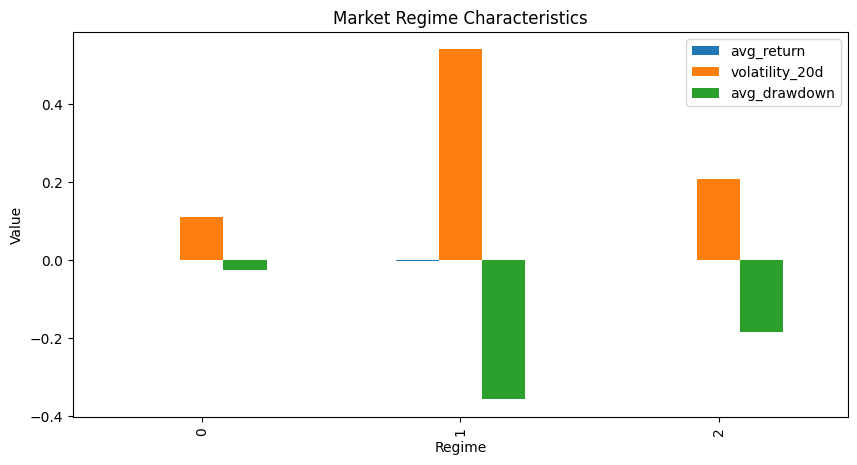

In [35]:
import matplotlib.pyplot as plt

regime_summary[
    ["avg_return", "volatility_20d", "avg_drawdown"]
].plot(kind="bar", figsize=(10, 5))

plt.title("Market Regime Characteristics")
plt.xlabel("Regime")
plt.ylabel("Value")
plt.show()


In [36]:
data["regime"].value_counts(normalize=True)

regime
0    0.661192
2    0.295264
1    0.043545
Name: proportion, dtype: float64

In [37]:
# shift regime to get next-day regime
data["next_regime"] = data["regime"].shift(-1)

# remove last NaN row
transition_data = data.dropna(subset=["next_regime"])

In [38]:
transition_counts = pd.crosstab(
    transition_data["regime"],
    transition_data["next_regime"]
)

transition_counts


next_regime,0.0,1.0,2.0
regime,,,
0,3416,0,45
1,0,223,5
2,45,5,1496


In [39]:
transition_probs = transition_counts.div(
    transition_counts.sum(axis=1),
    axis=0
)

transition_probs

next_regime,0.0,1.0,2.0
regime,,,
0,0.986998,0.000000,0.013002
1,0.000000,0.978070,0.021930
2,0.029107,0.003234,0.967658


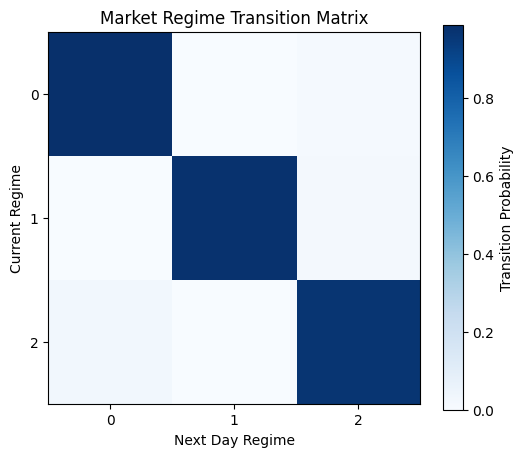

In [40]:
plt.figure(figsize=(6, 5))
plt.imshow(transition_probs, cmap="Blues")

plt.colorbar(label="Transition Probability")
plt.title("Market Regime Transition Matrix")

plt.xlabel("Next Day Regime")
plt.ylabel("Current Regime")

plt.xticks(range(len(transition_probs.columns)))
plt.yticks(range(len(transition_probs.index)))

plt.show()